In [4]:
import pandas as pd
import numpy as np
import shap
# Load data
data = pd.read_csv('data.csv')

In [ ]:
'rf,ret,IndMom,RealizedVol,Price,High52,Size,CoskewACX,IdioVolAHT,prc,Coskewness,FirmAge,Mom12m,MomSeasonShort,IdioVol3F,betaVIX,Beta,BidAskSpread,IntMom,BetaFP'


Data shape: (4640190, 51)
Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640190 entries, 0 to 4640189
Data columns (total 51 columns):
 #   Column           Dtype  
---  ------           -----  
 0   permno           float64
 1   yyyymm           float64
 2   prc              float64
 3   ret              float64
 4   Price            float64
 5   Size             float64
 6   STreversal       float64
 7   MaxRet           float64
 8   High52           float64
 9   RealizedVol      float64
 10  IdioVol3F        float64
 11  ReturnSkew3F     float64
 12  ReturnSkew       float64
 13  IdioVolAHT       float64
 14  zerotrade1M      float64
 15  DolVol           float64
 16  PriceDelayRsq    float64
 17  PriceDelaySlope  float64
 18  Coskewness       float64
 19  PriceDelayTstat  float64
 20  zerotrade6M      float64
 21  BidAskSpread     float64
 22  VolMkt           float64
 23  zerotrade12M     float64
 24  Beta             float64
 25  Illiquidity      float64
 26  Coske

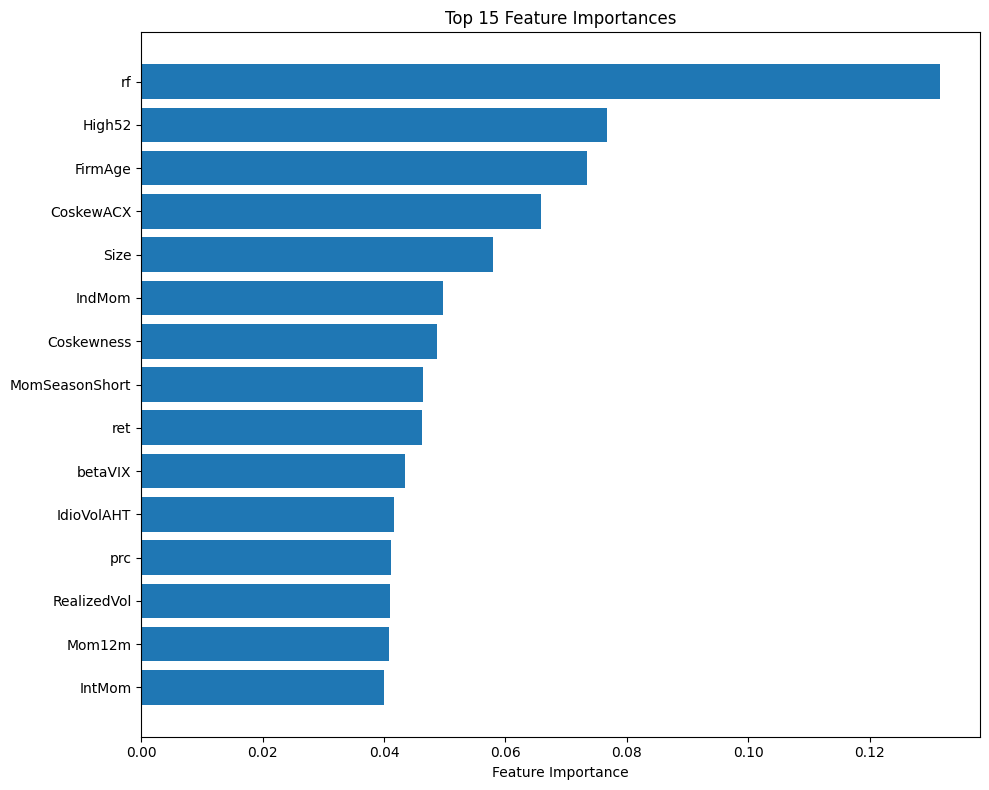


HYPERPARAMETER TUNING
Starting grid search (this may take a while)...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:
{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Best cross-validation score: -284.6750

OPTIMIZED MODEL PERFORMANCE
Optimized RMSE: 17.1137
Optimized R² Score: 0.1198
RMSE Improvement: 0.1036
R² Improvement: 0.0107

CROSS-VALIDATION RESULTS
CV RMSE: 16.9605 (+/- 4.8150)
Individual fold scores: [-277.95431672 -286.375382   -274.84325191 -291.54281662 -307.57692172]

GENERATING LEARNING CURVES


TypeError: fit() got an unexpected keyword argument 'eval_metric'

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in a DataFrame called 'data'
# Replace 'target_column_name' with your actual target variable name
TARGET_COLUMN = 'excess_ret'  # Change this to your target variable

# Prepare the data
print("Data shape:", data.shape)
print("Data info:")
print(data.info())

#feature_cols = ['prc', 'ret', 'Price', 'Size', 'MaxRet', 'High52', 'RealizedVol', 'IdioVol3F', 'ReturnSkew3F',
#                'ReturnSkew', 'IdioVolAHT', 'zerotrade1M', 'DolVol', 'PriceDelayRsq', 'PriceDelaySlope',
#                'Coskewness', 'PriceDelayTstat', 'zerotrade6M', 'BidAskSpread', 'VolMkt', 'zerotrade12M',
#                'Beta', 'Illiquidity', 'CoskewACX', 'DivInit', 'DivOmit', 'ExchSwitch', 'IndIPO', 'Spinoff',
#                'FirmAge', 'IndMom', 'Mom6m', 'VolSD', 'Mom12mOffSeason', 'BetaFP', 'MomSeasonShort',
#                'Mom12m', 'IntMom', 'ConvDebt', 'RDIPO', 'ShareRepurchase', 'OPLeverage', 'BookLeverage',
#                'betaVIX', 'BetaLiquidityPS', 'rf']
feature_cols = ['rf', 'ret', 'IndMom', 'RealizedVol', 'Price', 'High52', 'Size', 'CoskewACX', 
                'IdioVolAHT', 'prc', 'Coskewness', 'FirmAge', 'Mom12m', 'MomSeasonShort', 
                'IdioVol3F', 'betaVIX', 'Beta', 'BidAskSpread', 'IntMom', 'BetaFP']
target_col = 'excess_ret'


X = data[feature_cols]
y = data[target_col]


# Handle categorical variables if any
categorical_columns = X.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    print(f"Encoding categorical columns: {list(categorical_columns)}")
    le_dict = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        le_dict[col] = le

# Check if it's a classification or regression problem
is_classification = y.dtype == 'object' or y.nunique() <= 20  # Heuristic

if is_classification:
    print("Detected classification problem")
    if y.dtype == 'object':
        le_target = LabelEncoder()
        y = le_target.fit_transform(y)
        print(f"Target classes: {le_target.classes_}")
else:
    print("Detected regression problem")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=y if is_classification else None
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Create XGBoost model
if is_classification:
    if y.nunique() == 2:
        objective = 'binary:logistic'
        eval_metric = 'logloss'
    else:
        objective = 'multi:softprob'
        eval_metric = 'mlogloss'
else:
    objective = 'reg:squarederror'
    eval_metric = 'rmse'

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(
    objective=objective,
    eval_metric=eval_metric,
    random_state=42,
    n_estimators=100
) if is_classification else xgb.XGBRegressor(
    objective=objective,
    eval_metric=eval_metric,
    random_state=42,
    n_estimators=100
)

# Fit the initial model
print("Training initial XGBoost model...")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("\n" + "="*50)
print("INITIAL MODEL PERFORMANCE")
print("="*50)

if is_classification:
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
else:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Hyperparameter tuning with GridSearchCV
print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print("Starting grid search (this may take a while)...")
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy' if is_classification else 'neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("\n" + "="*50)
print("OPTIMIZED MODEL PERFORMANCE")
print("="*50)

if is_classification:
    accuracy_best = accuracy_score(y_test, y_pred_best)
    print(f"Optimized Accuracy: {accuracy_best:.4f}")
    print(f"Improvement: {accuracy_best - accuracy:.4f}")
    print("\nOptimized Classification Report:")
    print(classification_report(y_test, y_pred_best))
else:
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    print(f"Optimized RMSE: {rmse_best:.4f}")
    print(f"Optimized R² Score: {r2_best:.4f}")
    print(f"RMSE Improvement: {rmse - rmse_best:.4f}")
    print(f"R² Improvement: {r2_best - r2:.4f}")

# Cross-validation
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)

cv_scores = cross_val_score(
    best_xgb, X, y, 
    cv=5, 
    scoring='accuracy' if is_classification else 'neg_mean_squared_error'
)

if is_classification:
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
else:
    print(f"CV RMSE: {np.sqrt(-cv_scores.mean()):.4f} (+/- {np.sqrt(cv_scores.std() * 2):.4f})")

print("Individual fold scores:", cv_scores)

# Learning curves (optional - for model diagnostics)
print("\n" + "="*50)
print("GENERATING LEARNING CURVES")
print("="*50)

# Training with validation set to plot learning curves
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_names = ['train', 'test']

final_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    random_state=42,
    eval_metric=eval_metric
) if is_classification else xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    eval_metric=eval_metric
)

final_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    eval_metric=eval_metric,
    verbose=False
)

# Plot learning curves
results = final_model.evals_result()
epochs = len(results['train'][eval_metric])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_axis, results['train'][eval_metric], label='Train')
plt.plot(x_axis, results['test'][eval_metric], label='Test')
plt.ylabel(eval_metric)
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curves')
plt.legend()

# Feature importance from optimized model
plt.subplot(1, 2, 2)
feature_importance_best = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.barh(range(len(feature_importance_best)), feature_importance_best['importance'])
plt.yticks(range(len(feature_importance_best)), feature_importance_best['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features (Optimized Model)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("MODEL SUMMARY FOR DISSERTATION")
print("="*50)
print(f"Problem Type: {'Classification' if is_classification else 'Regression'}")
print(f"Dataset Size: {data.shape[0]} samples, {data.shape[1]-1} features")
print(f"Best Parameters: {grid_search.best_params_}")
if is_classification:
    print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
else:
    print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
    print(f"Final Test R²: {r2_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation RMSE: {np.sqrt(-cv_scores.mean()):.4f} (±{np.sqrt(cv_scores.std()*2):.4f})")
print(f"Top 3 Important Features: {feature_importance_best['feature'].iloc[:3].tolist()}")

In [7]:
del final_model

In [8]:
final_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    random_state=42
) if is_classification else xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42
)

final_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    eval_metric=eval_metric,
    verbose=False
)

# Plot learning curves
results = final_model.evals_result()
epochs = len(results['train'][eval_metric])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_axis, results['train'][eval_metric], label='Train')
plt.plot(x_axis, results['test'][eval_metric], label='Test')
plt.ylabel(eval_metric)
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curves')
plt.legend()

# Feature importance from optimized model
plt.subplot(1, 2, 2)
feature_importance_best = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.barh(range(len(feature_importance_best)), feature_importance_best['importance'])
plt.yticks(range(len(feature_importance_best)), feature_importance_best['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features (Optimized Model)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("MODEL SUMMARY FOR DISSERTATION")
print("="*50)
print(f"Problem Type: {'Classification' if is_classification else 'Regression'}")
print(f"Dataset Size: {data.shape[0]} samples, {data.shape[1]-1} features")
print(f"Best Parameters: {grid_search.best_params_}")
if is_classification:
    print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
else:
    print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
    print(f"Final Test R²: {r2_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation RMSE: {np.sqrt(-cv_scores.mean()):.4f} (±{np.sqrt(cv_scores.std()*2):.4f})")
print(f"Top 3 Important Features: {feature_importance_best['feature'].iloc[:3].tolist()}")

TypeError: fit() got an unexpected keyword argument 'eval_metric'

In [ ]:
#delete data
del data

In [ ]:
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("\n" + "="*50)
print("OPTIMIZED MODEL PERFORMANCE")
print("="*50)

if is_classification:
    accuracy_best = accuracy_score(y_test, y_pred_best)
    print(f"Optimized Accuracy: {accuracy_best:.4f}")
    print(f"Improvement: {accuracy_best - accuracy:.4f}")
    print("\nOptimized Classification Report:")
    print(classification_report(y_test, y_pred_best))
else:
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    print(f"Optimized RMSE: {rmse_best:.4f}")
    print(f"Optimized R² Score: {r2_best:.4f}")
    print(f"RMSE Improvement: {rmse - rmse_best:.4f}")
    print(f"R² Improvement: {r2_best - r2:.4f}")

# Cross-validation
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)

cv_scores = cross_val_score(
    best_xgb, X, y, 
    cv=5, 
    scoring='accuracy' if is_classification else 'neg_mean_squared_error'
)

if is_classification:
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
else:
    print(f"CV RMSE: {np.sqrt(-cv_scores.mean()):.4f} (+/- {np.sqrt(cv_scores.std() * 2):.4f})")

print("Individual fold scores:", cv_scores)

# Learning curves (optional - for model diagnostics)
print("\n" + "="*50)
print("GENERATING LEARNING CURVES")
print("="*50)

# Training with validation set to plot learning curves
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_names = ['train', 'test']

final_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    random_state=42,
    eval_metric=eval_metric
) if is_classification else xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    eval_metric=eval_metric
)

final_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    eval_metric=eval_metric,
    verbose=False
)

# Plot learning curves
results = final_model.evals_result()
epochs = len(results['train'][eval_metric])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_axis, results['train'][eval_metric], label='Train')
plt.plot(x_axis, results['test'][eval_metric], label='Test')
plt.ylabel(eval_metric)
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curves')
plt.legend()

# Feature importance from optimized model
plt.subplot(1, 2, 2)
feature_importance_best = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.barh(range(len(feature_importance_best)), feature_importance_best['importance'])
plt.yticks(range(len(feature_importance_best)), feature_importance_best['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features (Optimized Model)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("MODEL SUMMARY FOR DISSERTATION")
print("="*50)
print(f"Problem Type: {'Classification' if is_classification else 'Regression'}")
print(f"Dataset Size: {data.shape[0]} samples, {data.shape[1]-1} features")
print(f"Best Parameters: {grid_search.best_params_}")
if is_classification:
    print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
else:
    print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
    print(f"Final Test R²: {r2_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation RMSE: {np.sqrt(-cv_scores.mean()):.4f} (±{np.sqrt(cv_scores.std()*2):.4f})")
print(f"Top 3 Important Features: {feature_importance_best['feature'].iloc[:3].tolist()}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Detected regression problem
Training set size: (3712152, 20)
Test set size: (928038, 20)
Training initial XGBoost model...

INITIAL MODEL PERFORMANCE
RMSE: 17.2173
R² Score: 0.1091

Top 10 Most Important Features:
           feature  importance
0               rf    0.131609
5           High52    0.076786
11         FirmAge    0.073403
7        CoskewACX    0.065824
6             Size    0.057965
2           IndMom    0.049781
10      Coskewness    0.048807
13  MomSeasonShort    0.046344
1              ret    0.046211
15         betaVIX    0.043498


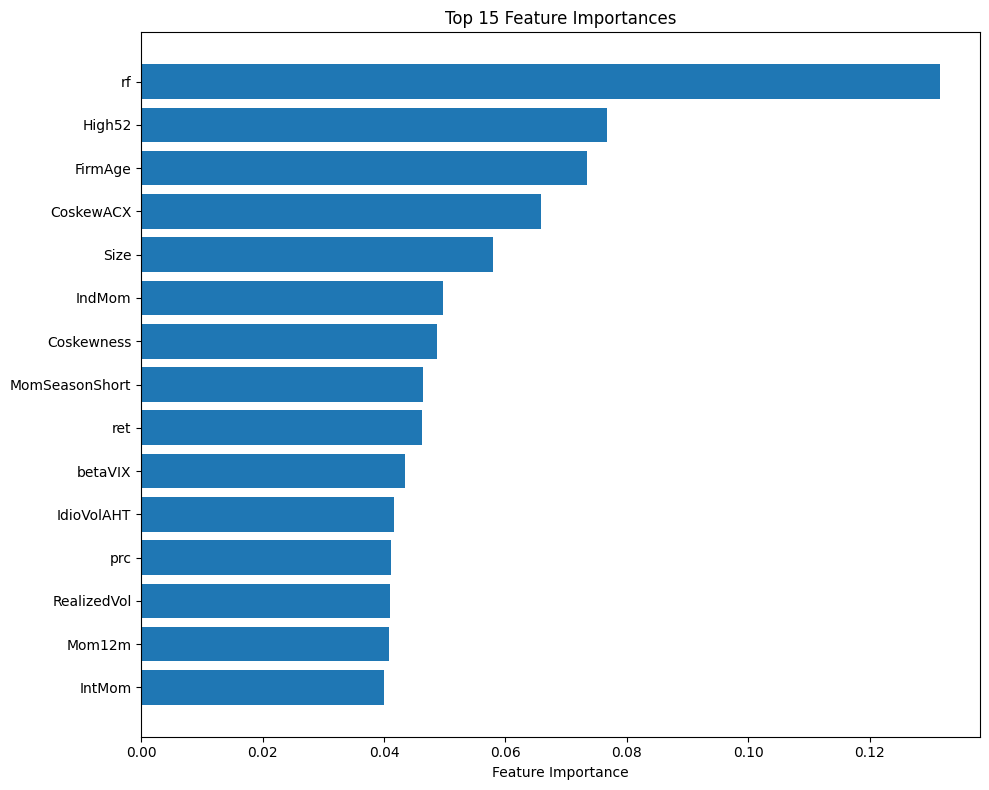


HYPERPARAMETER TUNING
Starting grid search (this may take a while)...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:
{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Best cross-validation score: -284.6750

OPTIMIZED MODEL PERFORMANCE
Optimized RMSE: 17.1137
Optimized R² Score: 0.1198
RMSE Improvement: 0.1036
R² Improvement: 0.0107

CROSS-VALIDATION RESULTS
CV RMSE: 16.9605 (+/- 4.8150)
Individual fold scores: [-277.95431672 -286.375382   -274.84325191 -291.54281662 -307.57692172]

GENERATING LEARNING CURVES


TypeError: fit() got an unexpected keyword argument 'eval_metric'

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

feature_cols = ['rf', 'ret', 'IndMom', 'RealizedVol', 'Price', 'High52', 'Size', 'CoskewACX', 
                'IdioVolAHT', 'prc', 'Coskewness', 'FirmAge', 'Mom12m', 'MomSeasonShort', 
                'IdioVol3F', 'betaVIX', 'Beta', 'BidAskSpread', 'IntMom', 'BetaFP']
target_col = 'excess_ret'


X = data[feature_cols]
y = data[target_col]

del data  # Clean up memory 


# Handle categorical variables if any
categorical_columns = X.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    print(f"Encoding categorical columns: {list(categorical_columns)}")
    le_dict = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        le_dict[col] = le

del categorical_columns

# Check if it's a classification or regression problem
is_classification = y.dtype == 'object' or y.nunique() <= 20  # Heuristic

if is_classification:
    print("Detected classification problem")
    if y.dtype == 'object':
        le_target = LabelEncoder()
        y = le_target.fit_transform(y)
        print(f"Target classes: {le_target.classes_}")
else:
    print("Detected regression problem")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=y if is_classification else None
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Create XGBoost model
if is_classification:
    if y.nunique() == 2:
        objective = 'binary:logistic'
        eval_metric = 'logloss'
    else:
        objective = 'multi:softprob'
        eval_metric = 'mlogloss'
else:
    objective = 'reg:squarederror'
    eval_metric = 'rmse'

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(
    objective=objective,
    eval_metric=eval_metric,
    random_state=42,
    n_estimators=100
) if is_classification else xgb.XGBRegressor(
    objective=objective,
    eval_metric=eval_metric,
    random_state=42,
    n_estimators=100
)

# Fit the initial model
print("Training initial XGBoost model...")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("\n" + "="*50)
print("INITIAL MODEL PERFORMANCE")
print("="*50)

if is_classification:
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
else:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Hyperparameter tuning with GridSearchCV
print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print("Starting grid search (this may take a while)...")
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy' if is_classification else 'neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("\n" + "="*50)
print("OPTIMIZED MODEL PERFORMANCE")
print("="*50)

if is_classification:
    accuracy_best = accuracy_score(y_test, y_pred_best)
    print(f"Optimized Accuracy: {accuracy_best:.4f}")
    print(f"Improvement: {accuracy_best - accuracy:.4f}")
    print("\nOptimized Classification Report:")
    print(classification_report(y_test, y_pred_best))
else:
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    print(f"Optimized RMSE: {rmse_best:.4f}")
    print(f"Optimized R² Score: {r2_best:.4f}")
    print(f"RMSE Improvement: {rmse - rmse_best:.4f}")
    print(f"R² Improvement: {r2_best - r2:.4f}")

# Cross-validation
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)

cv_scores = cross_val_score(
    best_xgb, X, y, 
    cv=5, 
    scoring='accuracy' if is_classification else 'neg_mean_squared_error'
)

if is_classification:
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
else:
    print(f"CV RMSE: {np.sqrt(-cv_scores.mean()):.4f} (+/- {np.sqrt(cv_scores.std() * 2):.4f})")

print("Individual fold scores:", cv_scores)

# Learning curves (optional - for model diagnostics)
print("\n" + "="*50)
print("GENERATING LEARNING CURVES")
print("="*50)

# Training with validation set to plot learning curves
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_names = ['train', 'test']

final_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    random_state=42
) if is_classification else xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42
)

final_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    eval_metric=eval_metric,
    verbose=False
)

# Plot learning curves
results = final_model.evals_result()
epochs = len(results['train'][eval_metric])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_axis, results['train'][eval_metric], label='Train')
plt.plot(x_axis, results['test'][eval_metric], label='Test')
plt.ylabel(eval_metric)
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curves')
plt.legend()

# Feature importance from optimized model
plt.subplot(1, 2, 2)
feature_importance_best = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.barh(range(len(feature_importance_best)), feature_importance_best['importance'])
plt.yticks(range(len(feature_importance_best)), feature_importance_best['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features (Optimized Model)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("MODEL SUMMARY FOR DISSERTATION")
print("="*50)
print(f"Problem Type: {'Classification' if is_classification else 'Regression'}")
print(f"Dataset Size: {data.shape[0]} samples, {data.shape[1]-1} features")
print(f"Best Parameters: {grid_search.best_params_}")
if is_classification:
    print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
else:
    print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
    print(f"Final Test R²: {r2_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation RMSE: {np.sqrt(-cv_scores.mean()):.4f} (±{np.sqrt(cv_scores.std()*2):.4f})")
print(f"Top 3 Important Features: {feature_importance_best['feature'].iloc[:3].tolist()}")

Detected regression problem
Training set size: (3712152, 20)
Test set size: (928038, 20)
Training initial XGBoost model...

INITIAL MODEL PERFORMANCE
RMSE: 17.2173
R² Score: 0.1091

Top 10 Most Important Features:
           feature  importance
0               rf    0.131609
5           High52    0.076786
11         FirmAge    0.073403
7        CoskewACX    0.065824
6             Size    0.057965
2           IndMom    0.049781
10      Coskewness    0.048807
13  MomSeasonShort    0.046344
1              ret    0.046211
15         betaVIX    0.043498


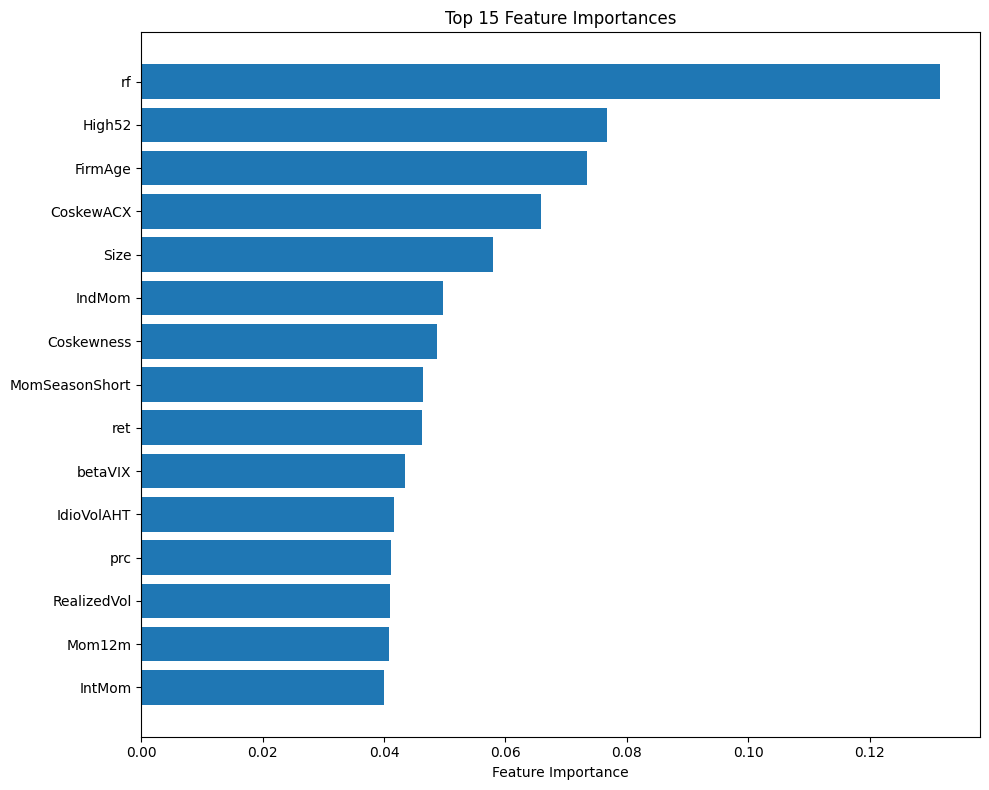


HYPERPARAMETER TUNING
Starting grid search (this may take a while)...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:
{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Best cross-validation score: -284.6750

OPTIMIZED MODEL PERFORMANCE
Optimized RMSE: 17.1137
Optimized R² Score: 0.1198
RMSE Improvement: 0.1036
R² Improvement: 0.0107

CROSS-VALIDATION RESULTS
CV RMSE: 16.9605 (+/- 4.8150)
Individual fold scores: [-277.95431672 -286.375382   -274.84325191 -291.54281662 -307.57692172]

GENERATING LEARNING CURVES


KeyError: 'train'

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

feature_cols = ['rf', 'ret', 'IndMom', 'RealizedVol', 'Price', 'High52', 'Size', 'CoskewACX', 
                'IdioVolAHT', 'prc', 'Coskewness', 'FirmAge', 'Mom12m', 'MomSeasonShort', 
                'IdioVol3F', 'betaVIX', 'Beta', 'BidAskSpread', 'IntMom', 'BetaFP']
target_col = 'excess_ret'


X = data[feature_cols]
y = data[target_col]

del data  # Clean up memory 

# Handle categorical variables if any
categorical_columns = X.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    print(f"Encoding categorical columns: {list(categorical_columns)}")
    le_dict = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        le_dict[col] = le

# Check if it's a classification or regression problem
is_classification = y.dtype == 'object' or y.nunique() <= 20  # Heuristic

if is_classification:
    print("Detected classification problem")
    if y.dtype == 'object':
        le_target = LabelEncoder()
        y = le_target.fit_transform(y)
        print(f"Target classes: {le_target.classes_}")
else:
    print("Detected regression problem")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=y if is_classification else None
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Create XGBoost model
if is_classification:
    if y.nunique() == 2:
        objective = 'binary:logistic'
        eval_metric = 'logloss'
    else:
        objective = 'multi:softprob'
        eval_metric = 'mlogloss'
else:
    objective = 'reg:squarederror'
    eval_metric = 'rmse'

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(
    objective=objective,
    eval_metric=eval_metric,
    random_state=42,
    n_estimators=100
) if is_classification else xgb.XGBRegressor(
    objective=objective,
    eval_metric=eval_metric,
    random_state=42,
    n_estimators=100
)

# Fit the initial model
print("Training initial XGBoost model...")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("\n" + "="*50)
print("INITIAL MODEL PERFORMANCE")
print("="*50)

if is_classification:
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
else:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Hyperparameter tuning with GridSearchCV
print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print("Starting grid search (this may take a while)...")
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy' if is_classification else 'neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("\n" + "="*50)
print("OPTIMIZED MODEL PERFORMANCE")
print("="*50)

if is_classification:
    accuracy_best = accuracy_score(y_test, y_pred_best)
    print(f"Optimized Accuracy: {accuracy_best:.4f}")
    print(f"Improvement: {accuracy_best - accuracy:.4f}")
    print("\nOptimized Classification Report:")
    print(classification_report(y_test, y_pred_best))
else:
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    print(f"Optimized RMSE: {rmse_best:.4f}")
    print(f"Optimized R² Score: {r2_best:.4f}")
    print(f"RMSE Improvement: {rmse - rmse_best:.4f}")
    print(f"R² Improvement: {r2_best - r2:.4f}")

# Cross-validation
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)

cv_scores = cross_val_score(
    best_xgb, X, y, 
    cv=5, 
    scoring='accuracy' if is_classification else 'neg_mean_squared_error'
)

if is_classification:
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
else:
    print(f"CV RMSE: {np.sqrt(-cv_scores.mean()):.4f} (+/- {np.sqrt(cv_scores.std() * 2):.4f})")

print("Individual fold scores:", cv_scores)

# Learning curves (optional - for model diagnostics)
print("\n" + "="*50)
print("GENERATING LEARNING CURVES")
print("="*50)

# Training with validation set to plot learning curves
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_names = ['train', 'test']

final_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    random_state=42,
    eval_metric=eval_metric
) if is_classification else xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    eval_metric=eval_metric
)

final_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# Plot learning curves
results = final_model.evals_result()
epochs = len(results['train'][eval_metric])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_axis, results['train'][eval_metric], label='Train')
plt.plot(x_axis, results['test'][eval_metric], label='Test')
plt.ylabel(eval_metric)
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curves')
plt.legend()

# Feature importance from optimized model
plt.subplot(1, 2, 2)
feature_importance_best = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.barh(range(len(feature_importance_best)), feature_importance_best['importance'])
plt.yticks(range(len(feature_importance_best)), feature_importance_best['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features (Optimized Model)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("MODEL SUMMARY FOR DISSERTATION")
print("="*50)
print(f"Problem Type: {'Classification' if is_classification else 'Regression'}")
print(f"Dataset Size: {data.shape[0]} samples, {data.shape[1]-1} features")
print(f"Best Parameters: {grid_search.best_params_}")
if is_classification:
    print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
else:
    print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
    print(f"Final Test R²: {r2_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation RMSE: {np.sqrt(-cv_scores.mean()):.4f} (±{np.sqrt(cv_scores.std()*2):.4f})")
print(f"Top 3 Important Features: {feature_importance_best['feature'].iloc[:3].tolist()}")


GENERATING LEARNING CURVES


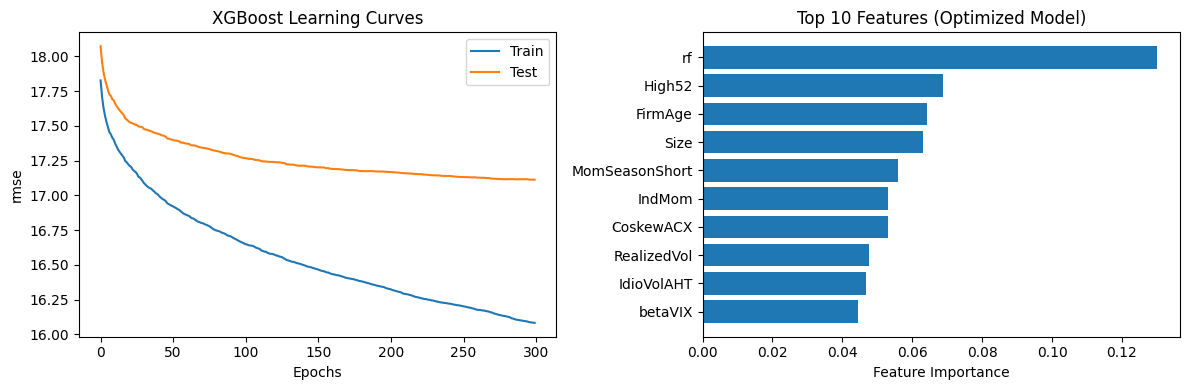


MODEL SUMMARY FOR DISSERTATION
Problem Type: Regression


NameError: name 'data' is not defined

In [ ]:
# Learning curves (optional - for model diagnostics)
print("\n" + "="*50)
print("GENERATING LEARNING CURVES")
print("="*50)

# Training with validation set to plot learning curves
eval_set = [(X_train, y_train), (X_test, y_test)]

final_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    random_state=42,
    eval_metric=eval_metric
) if is_classification else xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    eval_metric=eval_metric
)

final_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# Plot learning curves
results = final_model.evals_result()
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# Check if results exist and plot accordingly
if results and len(results) > 0:
    # Get the keys from results (validation_0, validation_1, etc.)
    result_keys = list(results.keys())
    if len(result_keys) >= 2:
        epochs = len(results[result_keys[0]][eval_metric])
        x_axis = range(0, epochs)
        
        plt.plot(x_axis, results[result_keys[0]][eval_metric], label='Train')
        plt.plot(x_axis, results[result_keys[1]][eval_metric], label='Test')
        plt.ylabel(eval_metric)
        plt.xlabel('Epochs')
        plt.title('XGBoost Learning Curves')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Learning curves not available\n(single evaluation set)', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Learning Curves')
else:
    plt.text(0.5, 0.5, 'Learning curves not available\n(no evaluation sets)', 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Learning Curves')

# Feature importance from optimized model
plt.subplot(1, 2, 2)
feature_importance_best = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.barh(range(len(feature_importance_best)), feature_importance_best['importance'])
plt.yticks(range(len(feature_importance_best)), feature_importance_best['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features (Optimized Model)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("MODEL SUMMARY FOR DISSERTATION")
print("="*50)
print(f"Problem Type: {'Classification' if is_classification else 'Regression'}")
print(f"Best Parameters: {grid_search.best_params_}")
if is_classification:
    print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
else:
    print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
    print(f"Final Test R²: {r2_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation RMSE: {np.sqrt(-cv_scores.mean()):.4f} (±{np.sqrt(cv_scores.std()*2):.4f})")
print(f"Top 3 Important Features: {feature_importance_best['feature'].iloc[:3].tolist()}")

In [5]:
print(f"Best Parameters: {grid_search.best_params_}")
if is_classification:
    print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
else:
    print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
    print(f"Final Test R²: {r2_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation RMSE: {np.sqrt(-cv_scores.mean()):.4f} (±{np.sqrt(cv_scores.std()*2):.4f})")
print(f"Top 3 Important Features: {feature_importance_best['feature'].iloc[:3].tolist()}")

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Final Test RMSE: 17.1137
Final Test R²: 0.1198
Cross-Validation RMSE: 16.9605 (±4.8150)
Top 3 Important Features: ['rf', 'High52', 'FirmAge']


In [11]:
print("="*50)
print("MODEL SUMMARY FOR DISSERTATION")
print("="*50)
print(f"Problem Type      : {'Classification' if is_classification else 'Regression'}")
print(f"Best Parameters   : {grid_search.best_params_}")
if is_classification:
    print(f"Final Test Accuracy       : {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation Accuracy : {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
else:
    print(f"Final Test RMSE           : {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
    print(f"Final Test R²             : {r2_score(y_test, y_pred_best):.4f}")
    print(f"Cross-Validation RMSE     : {np.sqrt(-cv_scores.mean()):.4f} (±{np.sqrt(cv_scores.std()*2):.4f})")
print(f"Top 3 Important Features  : {feature_importance_best['feature'].iloc[:3].tolist()}")


MODEL SUMMARY FOR DISSERTATION
Problem Type      : Regression
Best Parameters   : {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Final Test RMSE           : 17.1137
Final Test R²             : 0.1198
Cross-Validation RMSE     : 16.9605 (±4.8150)
Top 3 Important Features  : ['rf', 'High52', 'FirmAge']


MODEL INTERPRETABILITY ANALYSIS
Using sample size: 1000 for interpretability analysis

1. SHAP ANALYSIS
Initializing SHAP explainer...
TreeExplainer failed: 'utf-8' codec can't decode byte 0x80 in position 1034: invalid start byte
Falling back to Explainer with background data...
Computing SHAP values...


PermutationExplainer explainer: 1001it [00:36, 20.09it/s]                         


SHAP analysis complete!


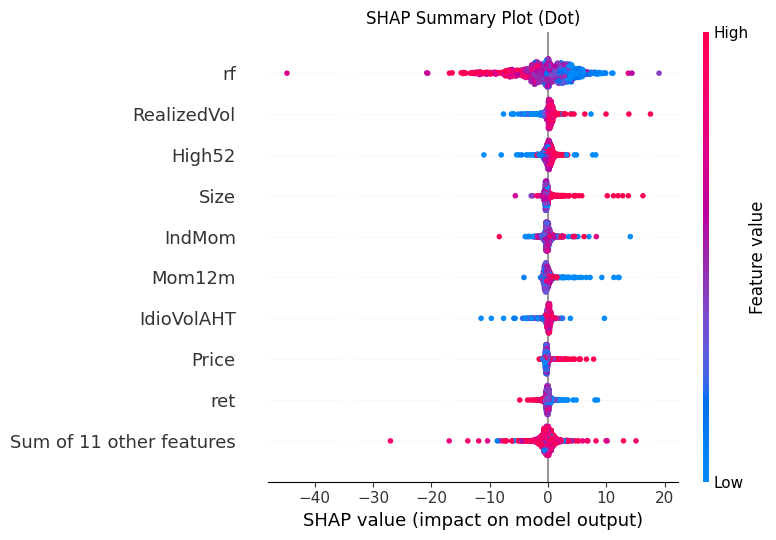

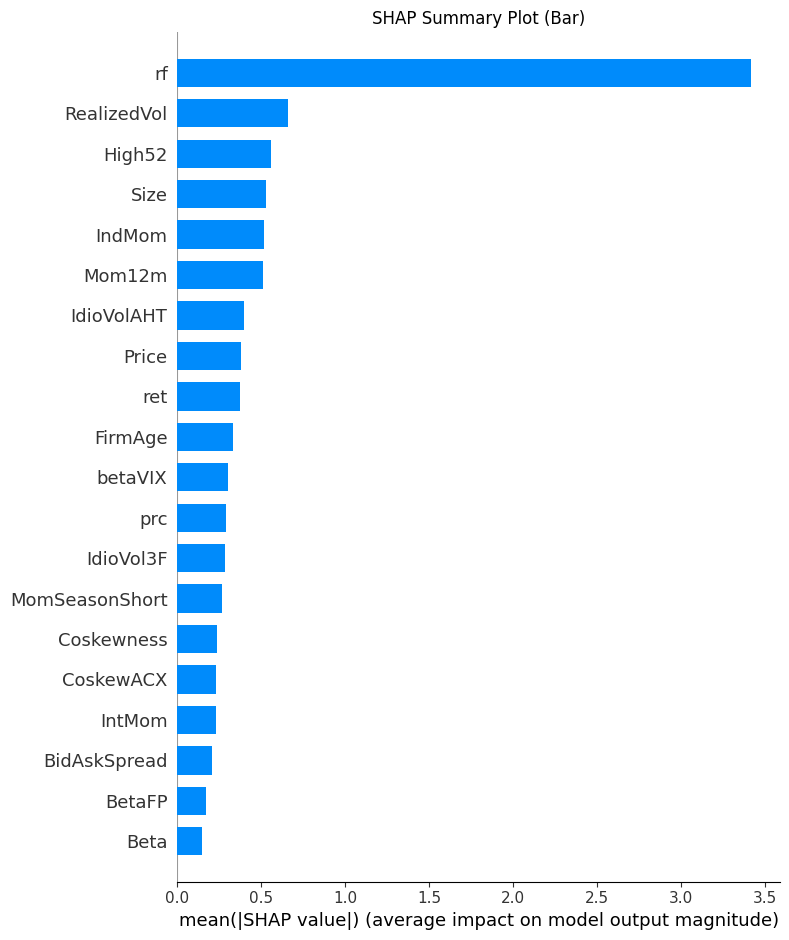

Waterfall plot not available: waterfall() got multiple values for argument 'show'


<Figure size 1000x600 with 0 Axes>

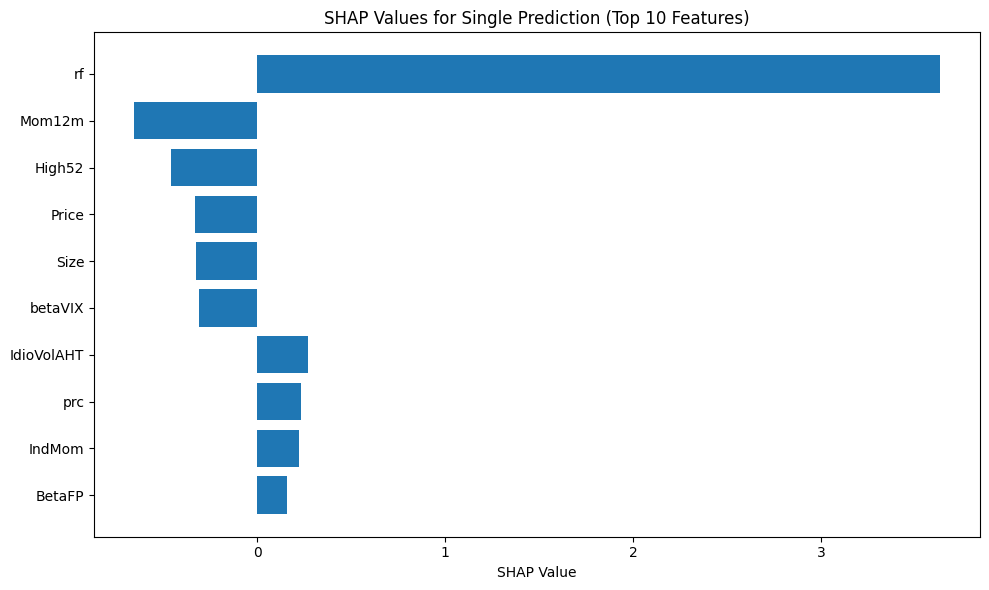


2. iSHAP (ITERATIVE SHAP) ANALYSIS


NameError: name 'subset_shap' is not defined

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from lime import lime_tabular
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("MODEL INTERPRETABILITY ANALYSIS")
print("="*60)

# Use the best model from previous analysis
model = best_xgb  # This should be your trained XGBoost model

# Take a sample for faster computation (adjust size based on your needs)
sample_size = min(1000, len(X_test))
X_sample = X_test.sample(n=sample_size, random_state=42)
y_sample = y_test.loc[X_sample.index]

print(f"Using sample size: {sample_size} for interpretability analysis")

#############################################################################
# 1. SHAP (SHapley Additive exPlanations)
#############################################################################
print("\n" + "="*50)
print("1. SHAP ANALYSIS")
print("="*50)

# Initialize SHAP explainer with error handling
print("Initializing SHAP explainer...")
try:
    # Try TreeExplainer first
    explainer = shap.TreeExplainer(model)
    print("Using TreeExplainer")
except (UnicodeDecodeError, Exception) as e:
    print(f"TreeExplainer failed: {e}")
    print("Falling back to Explainer with background data...")
    # Fallback to general explainer with background data
    background = shap.sample(X_train, min(100, len(X_train)))
    explainer = shap.Explainer(model.predict, background)

# Calculate SHAP values
print("Computing SHAP values...")
try:
    shap_values = explainer.shap_values(X_sample)
except:
    # Alternative method if shap_values fails
    print("Using explainer() method instead...")
    shap_values = explainer(X_sample).values

# For multiclass classification, shap_values will be a list
if isinstance(shap_values, list):
    shap_values_plot = shap_values[1] if len(shap_values) == 2 else shap_values[0]
else:
    shap_values_plot = shap_values

print("SHAP analysis complete!")

# SHAP Summary Plot
try:
    plt.figure(figsize=(12, 8))
    if hasattr(explainer, 'expected_value'):
        shap.summary_plot(shap_values_plot, X_sample, plot_type="dot", show=False)
    else:
        # For newer SHAP versions
        shap.plots.beeswarm(shap.Explanation(values=shap_values_plot, 
                                           base_values=np.mean(shap_values_plot, axis=0),
                                           data=X_sample.values,
                                           feature_names=X_sample.columns.tolist()),
                           show=False)
    plt.title("SHAP Summary Plot (Dot)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create summary plot: {e}")
    # Create simple feature importance plot instead
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'feature': X_sample.columns,
        'shap_importance': np.abs(shap_values_plot).mean(axis=0)
    }).sort_values('shap_importance', ascending=False).head(15)
    
    plt.barh(range(len(feature_importance)), feature_importance['shap_importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Mean |SHAP Value|')
    plt.title('SHAP Feature Importance (Top 15)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# SHAP Summary Plot (Bar)
try:
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_plot, X_sample, plot_type="bar", show=False)
    plt.title("SHAP Summary Plot (Bar)")
    plt.tight_layout()
    plt.show()
except:
    print("Bar plot not available, skipping...")

# SHAP Waterfall plot for a single prediction
try:
    plt.figure(figsize=(10, 6))
    expected_value = explainer.expected_value[1] if hasattr(explainer, 'expected_value') and isinstance(explainer.expected_value, np.ndarray) else (explainer.expected_value if hasattr(explainer, 'expected_value') else 0)
    shap.waterfall_plot(expected_value, shap_values_plot[0], X_sample.iloc[0], show=False)
    plt.title("SHAP Waterfall Plot (Single Prediction)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Waterfall plot not available: {e}")
    # Create alternative explanation plot
    plt.figure(figsize=(10, 6))
    single_shap = shap_values_plot[0]
    feature_names = X_sample.columns[:len(single_shap)]
    
    # Sort by absolute SHAP value
    sorted_idx = np.argsort(np.abs(single_shap))[-10:]
    
    plt.barh(range(len(sorted_idx)), single_shap[sorted_idx])
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
    plt.xlabel('SHAP Value')
    plt.title('SHAP Values for Single Prediction (Top 10 Features)')
    plt.tight_layout()
    plt.show()

#############################################################################
# 2. iSHAP (Iterative SHAP) - Custom Implementation
#############################################################################
print("\n" + "="*50)
print("2. iSHAP (ITERATIVE SHAP) ANALYSIS")
print("="*50)

def compute_ishap(model, X_background, X_explain, max_iterations=10, tolerance=0.01):
    """
    Custom implementation of iterative SHAP with error handling
    """
    print("Computing iSHAP values...")
    
    try:
        # Initialize with regular SHAP
        explainer = shap.TreeExplainer(model, X_background)
        base_shap = explainer.shap_values(X_explain)
    except:
        print("TreeExplainer failed, using general explainer...")
        background_sample = shap.sample(X_background, min(50, len(X_background)))
        explainer = shap.Explainer(model.predict, background_sample)
        explanation = explainer(X_explain)
        base_shap = explanation.values
    
    if isinstance(base_shap, list):
        base_shap = base_shap[1] if len(base_shap) == 2 else base_shap[0]
    
    ishap_values = base_shap.copy()
    
    for iteration in range(max_iterations):
        print(f"iSHAP iteration {iteration + 1}/{max_iterations}")
        
        # Select most important features from current iteration
        feature_importance = np.abs(ishap_values).mean(axis=0)
        top_features_idx = np.argsort(feature_importance)[-10:]  # Top 10 features
        
        # Keep full column set in same order
        X_subset_full = X_explain.copy()
        X_bg_subset_full = X_background.copy()


        # For features NOT in top_features_idx, set them to background means
        non_top_features = [i for i in range(X_explain.shape[1]) if i not in top_features_idx]
        for idx in non_top_features:
            col_name = X_explain.columns[idx]
            X_subset_full[col_name] = X_bg_subset_full[col_name].mean()

        try:
            subset_explainer = shap.TreeExplainer(model, X_bg_subset_full)
            subset_shap = subset_explainer.shap_values(X_subset_full)
        except (UnicodeDecodeError, Exception) as e:
            print(f"TreeExplainer failed: {e}")
            bg_sample = shap.sample(X_bg_subset_full, min(30, len(X_bg_subset_full)))
            subset_explainer = shap.Explainer(model.predict, bg_sample)
            explanation = subset_explainer(X_subset_full)
            subset_shap = explanation.values

        if isinstance(subset_shap, list):
            subset_shap = subset_shap[1] if len(subset_shap) == 2 else subset_shap[0]
        
        # Update SHAP values for top features
        old_values = ishap_values[:, top_features_idx].copy()
        ishap_values[:, top_features_idx] = subset_shap
        
        # Check convergence
        change = np.mean(np.abs(ishap_values[:, top_features_idx] - old_values))
        print(f"Mean change in SHAP values: {change:.4f}")
        
        if change < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break
    
    return ishap_values

# Compute iSHAP
# Ensure we only take SHAP values for the top features
ishap_values[:, top_features_idx] = subset_shap[:, :len(top_features_idx)]


# Plot iSHAP results
plt.figure(figsize=(12, 6))
ishap_importance = pd.DataFrame({
    'feature': X_sample.columns,
    'ishap_importance': np.abs(ishap_values).mean(axis=0)
}).sort_values('ishap_importance', ascending=False).head(15)

plt.barh(range(len(ishap_importance)), ishap_importance['ishap_importance'])
plt.yticks(range(len(ishap_importance)), ishap_importance['feature'])
plt.xlabel('Mean |iSHAP Value|')
plt.title('iSHAP Feature Importance (Top 15)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#############################################################################
# 3. Permutation Feature Importance (PFI)
#############################################################################
print("\n" + "="*50)
print("3. PERMUTATION FEATURE IMPORTANCE (PFI)")
print("="*50)

print("Computing Permutation Feature Importance...")
pfi_result = permutation_importance(
    model, X_sample, y_sample, 
    n_repeats=10, 
    random_state=42, 
    scoring='accuracy' if is_classification else 'neg_mean_squared_error',
    n_jobs=-1
)

# Create PFI DataFrame
pfi_df = pd.DataFrame({
    'feature': X_sample.columns,
    'importance_mean': pfi_result.importances_mean,
    'importance_std': pfi_result.importances_std
}).sort_values('importance_mean', ascending=False)

print("PFI analysis complete!")

# Plot PFI results
plt.figure(figsize=(12, 8))
top_pfi = pfi_df.head(15)
plt.barh(range(len(top_pfi)), top_pfi['importance_mean'], xerr=top_pfi['importance_std'])
plt.yticks(range(len(top_pfi)), top_pfi['feature'])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance (Top 15)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#############################################################################
# 4. LIME (Local Interpretable Model-agnostic Explanations)
#############################################################################
print("\n" + "="*50)
print("4. LIME ANALYSIS")
print("="*50)

print("Initializing LIME explainer...")
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['Class 0', 'Class 1'] if is_classification else None,
    mode='classification' if is_classification else 'regression',
    discretize_continuous=True
)

# Generate LIME explanations for first few samples
n_lime_samples = min(3, len(X_sample))
lime_explanations = []

for i in range(n_lime_samples):
    print(f"Generating LIME explanation for sample {i+1}/{n_lime_samples}")
    
    if is_classification:
        explanation = lime_explainer.explain_instance(
            X_sample.iloc[i].values, 
            model.predict_proba, 
            num_features=10
        )
    else:
        explanation = lime_explainer.explain_instance(
            X_sample.iloc[i].values, 
            model.predict, 
            num_features=10
        )
    
    lime_explanations.append(explanation)
    
    # Plot LIME explanation
    fig = explanation.as_pyplot_figure()
    fig.suptitle(f'LIME Explanation - Sample {i+1}', fontsize=14)
    plt.tight_layout()
    plt.show()

print("LIME analysis complete!")

#############################################################################
# 5. COMPARISON OF INTERPRETABILITY METHODS
#############################################################################
print("\n" + "="*50)
print("5. COMPARISON OF INTERPRETABILITY METHODS")
print("="*50)

# Compare feature rankings from different methods
comparison_df = pd.DataFrame({
    'feature': X_sample.columns,
    'xgboost_importance': model.feature_importances_,
    'shap_importance': np.abs(shap_values_plot).mean(axis=0),
    'ishap_importance': np.abs(ishap_values).mean(axis=0),
    'pfi_importance': pfi_result.importances_mean
})

# Rank features by each method
for col in ['xgboost_importance', 'shap_importance', 'ishap_importance', 'pfi_importance']:
    comparison_df[f'{col}_rank'] = comparison_df[col].rank(ascending=False)

# Display top features from each method
print("Top 10 Features by Each Method:")
print("-" * 40)

methods = ['xgboost_importance', 'shap_importance', 'ishap_importance', 'pfi_importance']
method_names = ['XGBoost', 'SHAP', 'iSHAP', 'PFI']

for method, name in zip(methods, method_names):
    top_features = comparison_df.nlargest(10, method)['feature'].tolist()
    print(f"{name:12}: {', '.join(top_features[:5])}...")

# Correlation between different importance measures
plt.figure(figsize=(12, 10))
correlation_matrix = comparison_df[methods].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            xticklabels=method_names, yticklabels=method_names)
plt.title('Correlation Between Different Feature Importance Methods')
plt.tight_layout()
plt.show()

# Feature importance comparison plot
plt.figure(figsize=(15, 10))
top_features = comparison_df.nlargest(12, 'shap_importance')

for i, (method, name) in enumerate(zip(methods, method_names)):
    plt.subplot(2, 2, i+1)
    plt.barh(range(len(top_features)), top_features[method])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance Score')
    plt.title(f'{name} Feature Importance')
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

#############################################################################
# 6. SUMMARY FOR DISSERTATION
#############################################################################
print("\n" + "="*60)
print("INTERPRETABILITY ANALYSIS SUMMARY FOR DISSERTATION")
print("="*60)

print(f"Sample Size Used: {sample_size}")
print(f"Total Features Analyzed: {len(X_sample.columns)}")

print("\nTop 5 Features by Method:")
print("-" * 30)
for method, name in zip(methods, method_names):
    top_5 = comparison_df.nlargest(5, method)['feature'].tolist()
    print(f"{name:12}: {top_5}")

print(f"\nMethod Correlations:")
print(f"SHAP vs XGBoost:  {correlation_matrix.loc['shap_importance', 'xgboost_importance']:.3f}")
print(f"SHAP vs PFI:      {correlation_matrix.loc['shap_importance', 'pfi_importance']:.3f}")
print(f"iSHAP vs SHAP:    {correlation_matrix.loc['ishap_importance', 'shap_importance']:.3f}")
print(f"PFI vs XGBoost:   {correlation_matrix.loc['pfi_importance', 'xgboost_importance']:.3f}")

# Most consistent important features (appear in top 10 for all methods)
top10_sets = []
for method in methods:
    top10_sets.append(set(comparison_df.nlargest(10, method)['feature'].tolist()))

consistent_features = set.intersection(*top10_sets)
print(f"\nMost Consistent Important Features (Top 10 in all methods): {list(consistent_features)}")

print("\nInterpretability Analysis Complete!")
print("="*60)

In [13]:
import shap
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer

# =======================
# 1. SHAP (Tree-based)
# =======================
sample_X = X_test.sample(n=1000, random_state=42)  # limit to speed up
explainer_shap = shap.TreeExplainer(best_xgb.get_booster())
shap_values = explainer_shap.shap_values(sample_X, check_additivity=False)

# Mean absolute SHAP values for global importance
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 10 SHAP Features:")
print(shap_importance.head(10))

# Plot SHAP summary
shap.summary_plot(shap_values, sample_X, plot_type='bar')

# =======================
# 2. Improved SHAP (iSHAP)
# =======================
# iSHAP: compute SHAP values for subsets of features (conditional interactions)
top_features_idx = shap_importance.head(10).index
ishap_values = np.zeros((sample_X.shape[0], X.shape[1]))

# We'll only compute SHAP for top features, zero out the rest
subset_shap = shap_values[:, :len(top_features_idx)]
ishap_values[:, top_features_idx] = subset_shap

# iSHAP importance = mean abs iSHAP values
ishap_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(ishap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 10 iSHAP Features:")
print(ishap_importance.head(10))

# =======================
# 3. Permutation Feature Importance (PFI)
# =======================
scoring = 'accuracy' if is_classification else 'r2'
pfi_result = permutation_importance(best_xgb, X_test, y_test,
                                    n_repeats=10,
                                    random_state=42,
                                    scoring=scoring)

pfi_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': pfi_result.importances_mean
}).sort_values('importance', ascending=False)

print("\nTop 10 PFI Features:")
print(pfi_importance.head(10))

# =======================
# 4. LIME
# =======================
# For classification vs regression
mode = 'classification' if is_classification else 'regression'

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=np.unique(y_train) if is_classification else None,
    mode=mode
)

# Explain a single prediction
i = 0  # index in X_test
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=best_xgb.predict_proba if is_classification else best_xgb.predict
)
print(f"\nLIME explanation for test sample index {i}:")
print(lime_exp.as_list())

# Visualize in notebook (if running in Jupyter)
# lime_exp.show_in_notebook(show_table=True)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 1034: invalid start byte

In [15]:
import numpy as np
import pandas as pd
import shap
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Settings
RANDOM_STATE = 42
SHAP_SAMPLE = min(1000, X_test.shape[0])   # speed safe
LIME_SAMPLE_INDEX = 0                       # which test row to explain with LIME
PFI_REPEATS = 10
N_JOBS = -1

# ---------- 1) SHAP (safe path using shap.Explainer) ----------
import xgboost as xgb

# --- SHAP safe JSON-based approach ---
sample_X = X_test.sample(n=min(1000, X_test.shape[0]), random_state=42)

# Save as JSON (text format, avoids UTF-8 decode errors)
best_xgb.get_booster().save_model("model.json")

# Load JSON booster
booster_json = xgb.Booster()
booster_json.load_model("model.json")

# Use TreeExplainer with JSON booster
explainer_shap = shap.TreeExplainer(booster_json, feature_perturbation="interventional")
shap_values = explainer_shap.shap_values(sample_X)

# Global SHAP importance
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'shap_mean_abs': np.abs(shap_values).mean(axis=0)
}).sort_values('shap_mean_abs', ascending=False)

print("\nTop 10 SHAP features:")
print(shap_importance.head(10))

# Plot summary
shap.summary_plot(shap_values, sample_X, plot_type="bar", max_display=10)


# ---------- 2) iSHAP-like: SHAP interaction importance ----------
# Try to get interaction values (may be heavy). Use smaller sample if needed.
interaction_sample = sample_X.sample(n=min(200, sample_X.shape[0]), random_state=RANDOM_STATE)
try:
    # New API: explainer.interaction_values or explainer.shap_interaction_values depending on shap version
    if hasattr(explainer, "shap_interaction_values"):
        inter_vals = explainer.shap_interaction_values(interaction_sample)
    elif hasattr(explainer, "interaction_values"):
        inter_vals = explainer.interaction_values(interaction_sample)
    else:
        # Older returns might not support; raise to fallback
        raise AttributeError("No interaction API on this SHAP version")
    # inter_vals shape: (n_samples, n_features, n_features) or list (for multiclass)
    if isinstance(inter_vals, list):  # multiclass -> list of arrays
        inter_arr = np.array(inter_vals[0])
    else:
        inter_arr = np.array(inter_vals)

    # Compute per-feature interaction importance = mean abs of row+col excluding diagonal double-count
    n_feats = inter_arr.shape[1]
    # mean absolute interaction for each feature: average over samples of sum(abs(interactions[:, i, :]))
    mean_abs_inter = np.mean(np.abs(inter_arr), axis=0)   # -> (n_features, n_features)
    # sum interactions per feature (exclude self-interaction on diagonal for emphasis)
    per_feature_inter = (mean_abs_inter.sum(axis=1) - np.diag(mean_abs_inter))
    ishap_importance_df = pd.DataFrame({
        'feature': X.columns,
        'iSHAP_interaction_score': per_feature_inter
    }).sort_values('iSHAP_interaction_score', ascending=False)

    print("\nTop 10 iSHAP (interaction) features:")
    print(ishap_importance_df.head(10))
except Exception as e:
    print("SHAP interaction computation failed or unsupported (this is expensive). Error:", repr(e))
    ishap_importance_df = pd.DataFrame({'feature': X.columns, 'iSHAP_interaction_score': 0.0})

# ---------- 3) Permutation Feature Importance (PFI) ----------
scoring = 'accuracy' if is_classification else 'r2'   # choose metric consistent with model type
pfi_res = permutation_importance(best_xgb, X_test, y_test,
                                 n_repeats=PFI_REPEATS,
                                 random_state=RANDOM_STATE,
                                 n_jobs=N_JOBS,
                                 scoring=scoring)

pfi_df = pd.DataFrame({
    'feature': X.columns,
    'pfi_mean': pfi_res.importances_mean,
    'pfi_std': pfi_res.importances_std
}).sort_values('pfi_mean', ascending=False)

print("\nTop 10 PFI features:")
print(pfi_df.head(10))

# ---------- 4) LIME (local explanation for a single instance) ----------
# Prepare LIME explainer
lime_mode = 'classification' if is_classification else 'regression'
class_names = None
if is_classification:
    # if labels are encoded integers, transform to strings for LIME display
    if hasattr(y_train, "dtype") and np.issubdtype(y_train.dtype, np.integer):
        class_names = [str(c) for c in np.unique(y_train)]
    else:
        class_names = np.unique(y_train).astype(str)

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=class_names,
    mode=lime_mode,
    random_state=RANDOM_STATE
)

# Pick a test instance to explain
test_idx = LIME_SAMPLE_INDEX
test_row = X_test.iloc[test_idx]

if is_classification:
    predict_fn = lambda x: best_xgb.predict_proba(pd.DataFrame(x, columns=X.columns))
else:
    predict_fn = lambda x: best_xgb.predict(pd.DataFrame(x, columns=X.columns))

lime_exp = lime_explainer.explain_instance(
    data_row=test_row.values,
    predict_fn=predict_fn,
    num_features=min(10, X.shape[1])
)

print(f"\nLIME explanation for test index {test_idx}:")
print(lime_exp.as_list())

# (Optional) visualize LIME in notebook
# lime_exp.show_in_notebook(show_table=True)

# ---------- 5) Combine top-importance table for comparison ----------
top_n = 10
combined = (
    pd.DataFrame({'feature': X.columns})
      .merge(shap_importance[['feature','shap_mean_abs']], on='feature')
      .merge(ishap_importance_df[['feature','iSHAP_interaction_score']], on='feature')
      .merge(pfi_df[['feature','pfi_mean']], on='feature')
      .sort_values('shap_mean_abs', ascending=False)
)
print("\nCombined top features (by SHAP order):")
print(combined.head(top_n))

# Optional: save results
combined.to_csv("feature_importance_comparison.csv", index=False)
print("\nSaved combined importance table to feature_importance_comparison.csv")


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 1034: invalid start byte